In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas, numpy, random
import matplotlib.pyplot as plt

In [2]:
# if CUDA is available, use GPU and set default tensor type to cuda

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: GeForce RTX 2080 Ti


device(type='cuda')

In [3]:
max_length_smiles = 29
input_para = 300

class Token(nn.Embedding):
    def __init__(self, vocab_size, embed_size=200, padding_idx=0):
        super().__init__(vocab_size, embed_size, padding_idx)
        
token = Token(30)

def convertToASCII(item):
    ascii = []
    for char in item:
        ascii.append(ord(char))
        
    return ascii

def convertASCIIToString(items):
    result = ""
    for item in items:
        #print("item", item)
        result = result + chr(item)
    return result

In [4]:
# dataset class

class qm9Dataset(Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None, skiprows=1, dtype='unicode')
        #print(self.data_df)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        smiles = (self.data_df.iloc[index,0] + " " * max_length_smiles)[0:max_length_smiles]
        smiles = torch.cuda.FloatTensor(convertToASCII(smiles)) / 128.0   #ascii max value
        
        labels = []
        labels.append(float(self.data_df.iloc[index,1]))
        labels.append(float(self.data_df.iloc[index,2]))
        labels.append(float(self.data_df.iloc[index,3]))
        labels.append(float(self.data_df.iloc[index,4]))
        labels.append(float(self.data_df.iloc[index,5]))
        labels.append(float(self.data_df.iloc[index,6]))
        labels.append(float(self.data_df.iloc[index,7]))
        labels.append(float(self.data_df.iloc[index,8]))
        labels.append(float(self.data_df.iloc[index,9]))
        labels.append(float(self.data_df.iloc[index,10]))
        labels.append(float(self.data_df.iloc[index,11]))
        labels.append(float(self.data_df.iloc[index,11]))
        labels.append(float(self.data_df.iloc[index,12]))
        
        labels = torch.cuda.FloatTensor(labels)
        
        target = torch.zeros((len(self.data_df))).to(device)
        target[index] = 1.0
        
        return smiles,labels,target
    
    pass

In [5]:
qm9dataset = qm9Dataset('dataset/qm9.csv')

In [6]:
qm9dataset[2]

(tensor([0.6172, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
         0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
         0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
         0.2500, 0.2500]),
 tensor([ 1.8511e+00,  6.3100e+00, -2.9280e-01,  6.8700e-02,  3.6150e-01,
          1.9000e+01,  2.1375e-02,  6.0020e+00, -7.6405e+01, -7.6402e+01,
         -7.6401e+01, -7.6401e+01, -7.6422e+01]),
 tensor([0., 0., 1.,  ..., 0., 0., 0.]))

In [7]:
from torch.utils.data import DataLoader
data_loader = torch.utils.data.DataLoader(qm9dataset,batch_size=1,shuffle=False)

'''
max_length_smiles = 0
i = 0
for smiles,label,target in data_loader:
    i += 1
    if (i % 1000 == 0):
        print(smiles)
    max_length_smiles = max(max_length_smiles, len(smiles[0]))
    #print("Max length smiles:", max_length_smiles)

    #max_length_smiles = 29
'''

'\nmax_length_smiles = 0\ni = 0\nfor smiles,label,target in data_loader:\n    i += 1\n    if (i % 1000 == 0):\n        print(smiles)\n    max_length_smiles = max(max_length_smiles, len(smiles[0]))\n    #print("Max length smiles:", max_length_smiles)\n\n    #max_length_smiles = 29\n'

In [8]:
def generate_random_smiles(size):
    random_length = random.randint(0, size-1)
    random_data = torch.randint(32, 128, (1,size))
    random_data[0][random_length:size] = 32   # space
    result = random_data.float()/128.0
    return result


def generate_random_one_hot(size):
    label_tensor = torch.zeros((size))
    random_idx = random.randint(0,size)
    label_tensor[random_idx] = 1.0
    return label_tensor

def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data


class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)
    
generate_random_smiles(max_length_smiles)    

tensor([[0.2969, 0.4062, 0.5234, 0.4688, 0.4688, 0.8438, 0.8203, 0.6406, 0.3203,
         0.6406, 0.8047, 0.5859, 0.6797, 0.4531, 0.2500, 0.4062, 0.2500, 0.2500,
         0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
         0.2500, 0.2500]])

In [9]:
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            View(max_length_smiles),
            
            #nn.Linear(30, 100),
            #nn.LeakyReLU(),
            
            #nn.LayerNorm(100),
            
            #nn.Linear(100, 1),
            #nn.Sigmoid()
            
            
            nn.Linear(max_length_smiles, 200),
            nn.Sigmoid(),
            nn.Linear(200,1),
            nn.Sigmoid()
            
        )
        
        # create loss function
        self.loss_function = nn.BCELoss()
        #nn.MSELoss()
        #nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # combine seed and label
        #inputs = torch.cat((image_tensor, label_tensor))
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        #print("inputs:", inputs)
        
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        #print("outputs", outputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [10]:
%%time
# test discriminator can separate real data from random noise


D = Discriminator()
D.to(device)

for smiles,label,target in data_loader:
    # real
    #print("smiles.shape", smiles.shape)
    D.train(smiles[0], torch.cuda.FloatTensor([1.0]))
    # fake
    D.train(generate_random_seed(max_length_smiles), torch.cuda.FloatTensor([0.0]))
    pass


counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
counter =  250000
counter =  260000
CPU times: user 6min 29s, sys: 6.06 s, total: 6min 35s
Wall time: 6min 33s


In [29]:
for i in range(4):
    #random.randint(0,20000)
    data_tensor,_,_ = qm9dataset[random.randint(0,130000)]
    print( D.forward( data_tensor ).item() )
    pass

for i in range(4):
    print( D.forward(generate_random_seed(max_length_smiles)).item() )
    pass

0.3821937143802643
0.47165951132774353
0.3576602637767792
0.796633243560791
1.8807127162290271e-06
2.449016831275702e-16
1.4395155858437647e-06
6.904752919596746e-13


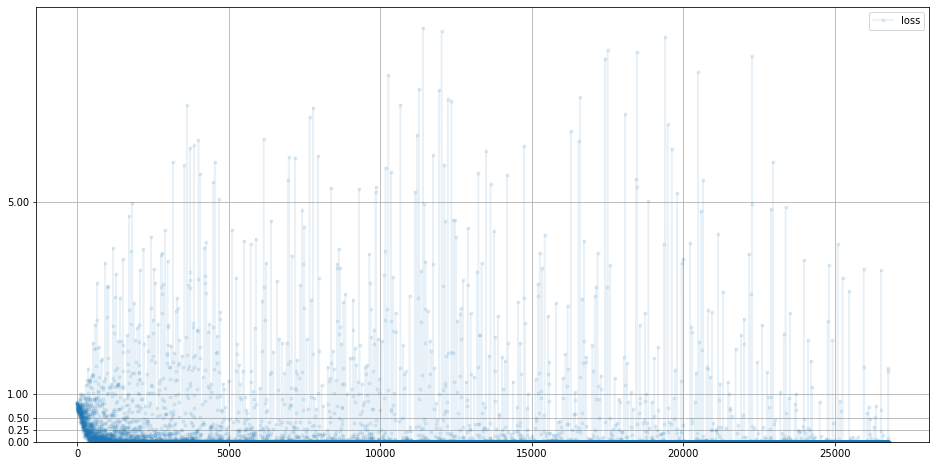

In [12]:
D.plot_progress()

In [13]:
class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            #nn.BatchNorm2d(input_para),
            #nn.Upsample(scale_factor=2),
            nn.Linear(input_para, 200),
            #nn.LeakyReLU(0.02),
            nn.ReLU(),

            #nn.LayerNorm(200),

            nn.Linear(200, max_length_smiles),
            nn.Sigmoid()
        )
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        return self.model(inputs)


    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [14]:
G = Generator()
G.to(device)

output = G.forward(generate_random_seed(input_para))

print("output", output)


output tensor([0.5237, 0.5080, 0.4639, 0.5045, 0.4750, 0.5300, 0.5262, 0.4736, 0.4092,
        0.5170, 0.4923, 0.5002, 0.4845, 0.4176, 0.4551, 0.5640, 0.6038, 0.4497,
        0.4711, 0.5802, 0.4049, 0.5345, 0.4157, 0.6091, 0.5413, 0.5196, 0.4009,
        0.5321, 0.4365], grad_fn=<SigmoidBackward>)


In [15]:
%%time 
D = Discriminator()
D.to(device)

G = Generator()
G.to(device)


epochs = 5

for epoch in range(epochs):
    print ("epoch = ", epoch + 1)

    i = 0
    # train Discriminator and Generator
    for smiles,label,target in data_loader:
        # train discriminator on true
        D.train(smiles[0], torch.cuda.FloatTensor([1.0]))

        # train discriminator on false
        # use detach() so gradients in G are not calculated
        #random_data = generate_random_smiles(input_para)
        
        #D.train(G.forward(generate_random_smiles(input_para)).detach(), torch.cuda.FloatTensor([0.0]))
        D.train(G.forward(generate_random_smiles(input_para)).detach()[0], torch.cuda.FloatTensor([0.0]))
            
        # train generator
        #G.train(D, generate_random_seed(input_para), torch.cuda.FloatTensor([1.0]))
        #G.train(D, generate_random_smiles(input_para), torch.cuda.FloatTensor([1.0]))
        G.train(D, generate_random_smiles(input_para), torch.cuda.FloatTensor([1.0]))
            
        i +=1

    pass
    
pass



import pickle
from datetime import datetime

now = datetime.now() 
date_time = now.strftime("%Y_%m_%d_%H_%M")
G_filename = 'pre_train_model/GAN2_G_' + date_time + '.sav'
print('save model to file:', G_filename)
pickle.dump(G, open(G_filename, 'wb'))

D_filename = 'pre_train_model/GAN2_D_' + date_time + '.sav'
print('save model to file:', D_filename)
pickle.dump(D, open(D_filename, 'wb'))

G_model = pickle.load(open(G_filename, 'rb'))
D_model = pickle.load(open(D_filename, 'rb'))

output = G_model.forward(generate_random_smiles(input_para))
D_model.forward(output)


epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
counter =  250000
counter =  260000
epoch =  2
counter =  270000
counter =  280000
counter =  290000
counter =  300000
counter =  310000
counter =  320000
counter =  330000
counter =  340000
counter =  350000
counter =  360000
counter =  370000
counter =  380000
counter =  390000
counter =  400000
counter =  410000
counter =  420000
counter =  430000
counter =  440000
counter =  450000
counter =  460000
counter =  470000
counter =  480000
counter =  490000
counter =  500000
counter =  510000
counter =  520000
counter =  530000
epoch =  3
counter =  540000
coun

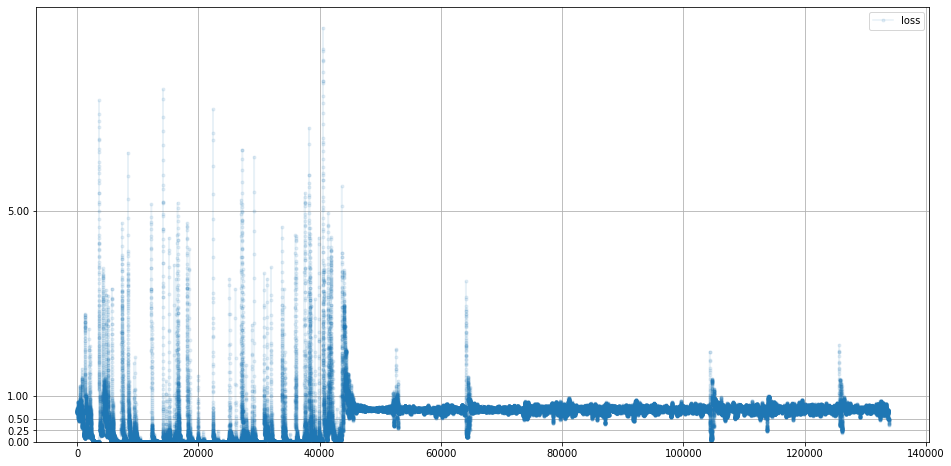

In [16]:
D.plot_progress()

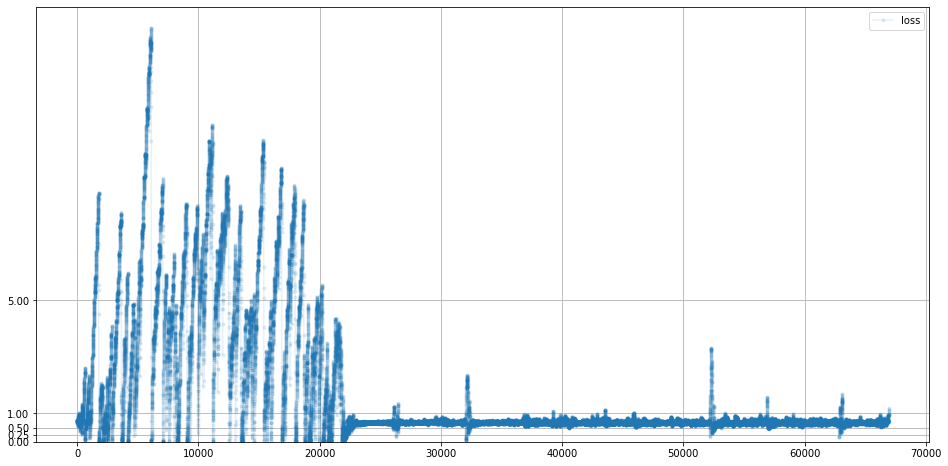

In [17]:
G.plot_progress()

In [18]:
for i in range(10):
    output = G.forward(generate_random_seed(input_para))
    smiles = output.detach().cpu().numpy() * 128
    print(convertASCIIToString(smiles))
    print("smiles:", smiles.astype(int) )           
    pass


g`hS>Ydll[NG;\YI#>&0#
smiles: [103  96 104  83  62  89 100 108 108  91  78  71  59  27  92  27  31  89
  28  30  73  35  62  16  38  31  21  48  35]
jZE6_pP\h,'!6
DG,=#+5
smiles: [106  90  69  54  28  95 112  80  92 104  44  39  33  14  54  10  27  68
  21  12  71  44  61  31  35  31  14  43  53]
e^F;75 ;>
smiles: [114  90  98  60  55  85 104  80  70 102  47  86  13  11 101  27  94  70
  59  55  53  20  30  32  23  59   2  28  62]
nRK=,]OS]J*M)R1=+%/$ -&)
smiles: [110  82  75  61  44  93  79  83  93  74  42  77  41  31  82  30  49  61
  43  37  47  36  30  32  31  45   8  38  41]
lt'QzUls7/6
,N
smiles: [108 116  39  31  15  81 122  85 108 115  55  14  26   8  47   5   7  54
  15  11  21  10  15  32  20  13   2  44  78]
g~a{suc^A{ {#aMef /V 5
smiles: [127 103 126  97 123 115 127 117  99  94  65 123   2   0 123  35  97  77
 101 102  32   8  17  47   5  86   0  21  53]
r-:W"3E&:1.
smiles: [114 106 121  91 103 104 121 122  95 113  88  92  

In [28]:
for i in range(10):
    data_tensor,_,_ = qm9dataset[random.randint(0,130000)]
    #print(D_model.forward(data_tensor).item())
    print(D.forward( data_tensor ).item() )

0.5153633952140808
0.41909360885620117
0.6075302958488464
0.800403356552124
0.27156731486320496
0.3282126784324646
0.5729001760482788
0.7334570288658142
0.7718483209609985
0.49504998326301575


In [30]:
for i in range(10):
    output = G.forward(generate_random_seed(input_para))
    print(D.forward( output ))

RuntimeError: shape '[29]' is invalid for input of size 300